In [1]:
#Standard imports for initial acquisition

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from env import get_db_url
import wrangle as w

In [2]:
#Getting filepath for zillow from CodeUp DB

z = get_db_url('zillow')

In [3]:
#Retrieving data as specified in exercise from DB
zillow = pd.read_sql('''SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips FROM properties_2017
	LEFT JOIN propertylandusetype USING (propertylandusetypeid)
    WHERE propertylandusedesc = 'Single Family Residential';''', z)

zillow.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


Before we take a look at the data, going to save it to local csv so I don't have to re-run this again.

In [4]:
zillow.to_csv('zillow.csv', index=False)

In [5]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152863 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 115.0 MB


Before we go any further, I want to rename some of the columns for clarity's sake.

(Did a Google search to find out what FIPS is. FIPS is a unique county identifier. Won't be using it to plot boxplots or histograms. More research revealed that they are counties in the Los Angeles area, so I'll rename those values since they're categorical variables.)

In [6]:
zillow = zillow.rename(columns={'bedroomcnt': 'bedrooms'
                       ,'bathroomcnt': 'bathrooms'
                       ,'calculatedfinishedsquarefeet': 'sqft'
                       ,'taxvaluedollarcnt': 'value'
                       ,'fips': 'county'
                      })

In [7]:
zillow.county.value_counts()

6037.0    1431811
6059.0     555077
6111.0     165975
Name: county, dtype: int64

In [8]:
zillow.county = zillow.county.replace([6037.0, 6059.0, 6111.0], ['LA', 'Orange', 'Ventura'])

For whatever reason, zillow.info( ) didn't include the Non-Null Count column... going to find them with isnull()

In [9]:
zillow.isnull().sum()

bedrooms       11
bathrooms      11
sqft         8484
value         493
yearbuilt    9337
taxamount    4442
county          0
dtype: int64

In [10]:
#Seems to be a small amount of nulls compared to dataset size. Dropping all rows with NA values

zillow = zillow.dropna()

Checking info again. Still not including the Non-Null count. Google says it's removed for really large dataframes

In [11]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152862
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   bedrooms   float64
 1   bathrooms  float64
 2   sqft       float64
 3   value      float64
 4   yearbuilt  float64
 5   taxamount  float64
 6   county     object 
dtypes: float64(6), object(1)
memory usage: 130.6+ MB


In [12]:
2152863 - 2140235 #Num of rows in original dataset minus #rows in new one

12628

In [13]:
12628/2152863 #Percentage of affected data

0.005865677472277613

12,628 rows were dropped from the original dataset of 2,152,863 rows, which is 0.5% of the dataset. I'm ok with that.

In [14]:
#Double-checking to see if any nulls are remaining.

zillow.isnull().any()

bedrooms     False
bathrooms    False
sqft         False
value        False
yearbuilt    False
taxamount    False
county       False
dtype: bool

We'll do an initial plotting of our data.

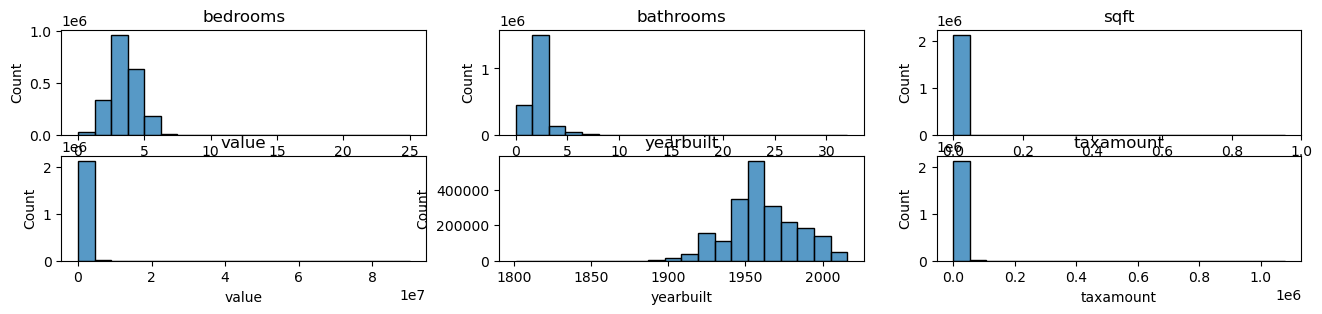

In [15]:
plt.figure(figsize=(16,3))

for i, col in enumerate(zillow.drop(columns='county')):
    plt.subplot(2,3,i+1)
    plt.title(col)
    sns.histplot(zillow[col], bins=20)
#   sns.histplot(zillow[col][zillow[col].between(zillow[col].quantile(.05), zillow[col].quantile(.95))])
#   plt.show()

Not terribly useful for sqft, value, and taxamount. Going to try using boxplots this time.

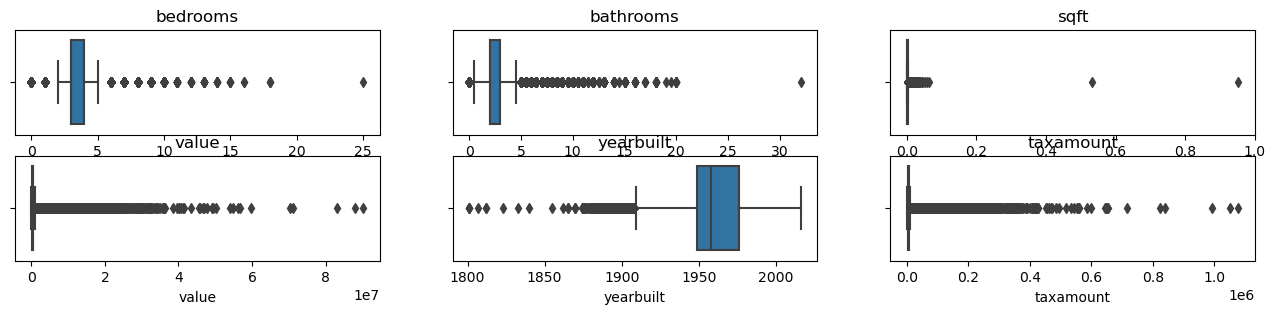

In [16]:
plt.figure(figsize=(16,3))

for i, col in enumerate(zillow.drop(columns='county')):
    plt.subplot(2,3,i+1)
    plt.title(col)
    sns.boxplot(data=zillow, x=zillow[col])
#    sns.boxplot(data=zillow, x=zillow[col][zillow[col].between(zillow[col].quantile(.05), zillow[col].quantile(.95))])

In deciding how to handle the outliers, looking at the above boxplots, I'm going to do see what these visualizations would look if the entire dataframe was just based on 3 standard deviations of number of bedrooms alone. 

In [17]:
lower_limit = zillow.bedrooms.mean() - (3 * zillow.bedrooms.std())

In [18]:
upper_limit = zillow.bedrooms.mean() + (3 * zillow.bedrooms.std())

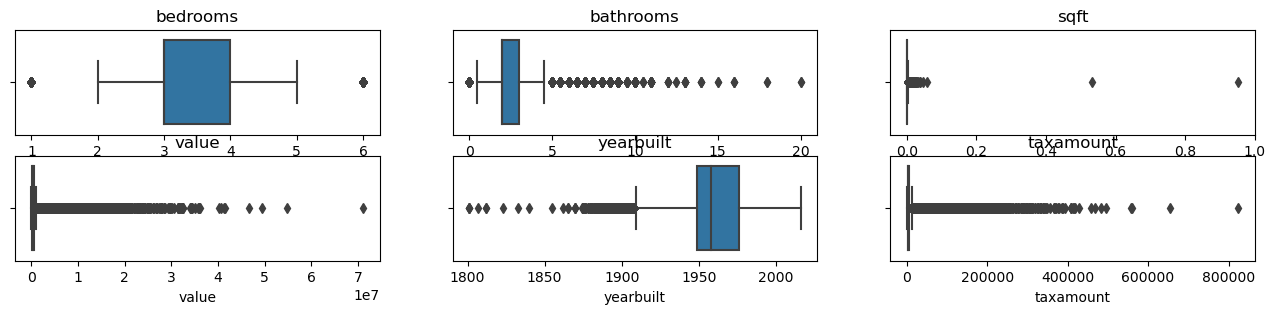

In [19]:
plt.figure(figsize=(16,3))

for i, col in enumerate(zillow.drop(columns='county')):
    plt.subplot(2,3,i+1)
    plt.title(col)
    sns.boxplot(data=zillow, x=zillow[col][zillow.bedrooms.between(lower_limit, upper_limit)])

Well... didn't seem to do much. I'm checking who exactly has so much square footage with less than 6 bedrooms...

In [20]:
zillow[zillow.sqft == zillow.sqft.max()]

,bedrooms,bathrooms,sqft,value,yearbuilt,taxamount,county
849924,4.0,4.0,952576.0,742727.0,1964.0,7694.72,Orange


The above seems... wrong. 1 million sqft for only 4 bd/bth, and it's somehow only $750,000?

Ok. Different approach. I'm going to handle outliers in the following fashion:

- bedrooms: cutting off properties with more than 10 bedrooms.
- bathrooms: cutting off properties with more than 10 bathrooms.
- sqft: cutting off properties in the top 1%
- value: cutting off properties in the top 1%
- yearbuilt: we'll leave it as is.
- taxamount: cutting off properties in the top 1%

In [21]:
zillow.bedrooms = zillow.bedrooms[zillow.bedrooms <= 10]
zillow.bathrooms = zillow.bathrooms[zillow.bathrooms <=10]
zillow.sqft = zillow.sqft[zillow.sqft < zillow.sqft.quantile(.99)]
zillow.value = zillow.value[zillow.value < zillow.value.quantile(.99)]
zillow.taxamount = zillow.taxamount[zillow.taxamount < zillow.taxamount.quantile(.99)]

Replotting to see how distributions look now.

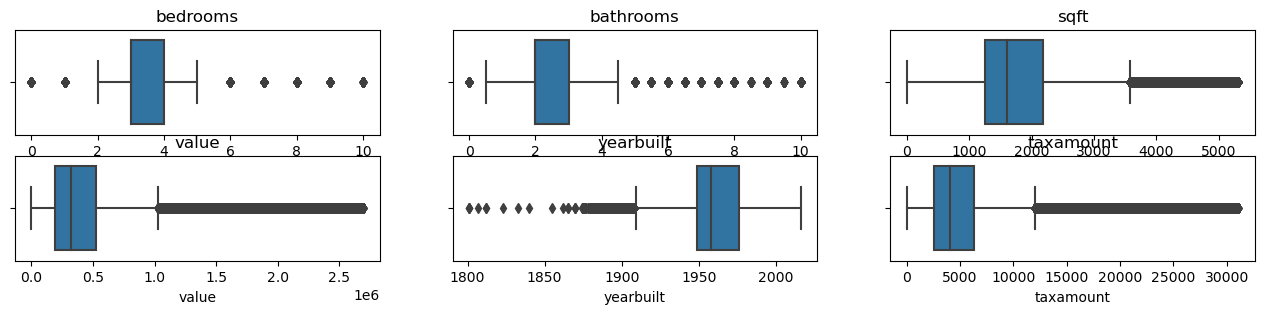

In [22]:
plt.figure(figsize=(16,3))

for i, col in enumerate(zillow.drop(columns='county')):
    plt.subplot(2,3,i+1)
    plt.title(col)
    sns.boxplot(data=zillow, x=zillow[col])

Ok, that looks better. Now we'll take a look at our new dataframe.

In [23]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152862
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   bedrooms   float64
 1   bathrooms  float64
 2   sqft       float64
 3   value      float64
 4   yearbuilt  float64
 5   taxamount  float64
 6   county     object 
dtypes: float64(6), object(1)
memory usage: 130.6+ MB


This shows that the original dataframe did not have any rows removed. There are new NaNs in place, however. And the dtypes switched again too...

In [24]:
zillow.isnull().sum()

bedrooms        79
bathrooms      353
sqft         21415
value        21403
yearbuilt        0
taxamount    21403
county           0
dtype: int64

We're going to drop those NaN values.

In [25]:
zillow = zillow.dropna()

In [26]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2105872 entries, 4 to 2152862
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   bedrooms   float64
 1   bathrooms  float64
 2   sqft       float64
 3   value      float64
 4   yearbuilt  float64
 5   taxamount  float64
 6   county     object 
dtypes: float64(6), object(1)
memory usage: 128.5+ MB


We're left with 2,105,872 rows from the original 2,152,863 rows. 

In [27]:
2105872 / 2152863 #Find percentage

0.9781727866566521

We've ended with 97.8% of the original dataset. Still plenty of data to work with.

I'm going to switch dtypes again...

In [28]:
zillow[['bedrooms', 'sqft', 'yearbuilt', 'value', 'taxamount']] = zillow[['bedrooms', 'sqft', 'yearbuilt', 'value', 'taxamount']].astype(int)

In [29]:
zillow.dtypes

bedrooms       int64
bathrooms    float64
sqft           int64
value          int64
yearbuilt      int64
taxamount      int64
county        object
dtype: object

That's better.

Ok, I put all of the above in the wrangle.py file. Running it below to see if it works.

In [30]:
zillow = w.wrangle_zillow()

In [31]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2105872 entries, 4 to 2152862
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   bedrooms   int64  
 1   bathrooms  float64
 2   sqft       int64  
 3   value      int64  
 4   yearbuilt  int64  
 5   taxamount  int64  
 6   county     object 
dtypes: float64(1), int64(5), object(1)
memory usage: 128.5+ MB


In [32]:
zillow.isnull().any()

bedrooms     False
bathrooms    False
sqft         False
value        False
yearbuilt    False
taxamount    False
county       False
dtype: bool

In [33]:
zillow.head()

,bedrooms,bathrooms,sqft,value,yearbuilt,taxamount,county
4,4,2.0,3633,296425,2005,6941,LA
6,3,4.0,1620,847770,2011,10244,LA
7,3,2.0,2077,646760,1926,7924,LA
11,0,0.0,1200,5328,1972,91,LA
14,0,0.0,171,6920,1973,255,LA


It works!